In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,  accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.linear_model import Lasso,ElasticNet,LassoLarsIC,BayesianRidge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, median_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BA - Project 2/Data/online_retail_II.csv')
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
df = data.copy()

In [ ]:
df = data.drop_duplicates()

# # Top ten country's customer
# filteredData.Country.value_counts()[:10].plot(kind='bar')
# plt.show(block=False)

# uk_data = data[data['Country'] == 'United Kingdom']

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df= df[(df['Quantity'] > 0)]

# use only required columns for CLTV
df = df[['Customer ID', 'InvoiceDate', 'StockCode', 'Quantity', 'Price', 'Country']]

# calculate total purchase
df['TotalPurchase'] = df['Quantity'] * df['Price']

# perform aggregate operations
df_grp = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (date.max() - date.min()).days,
    'StockCode': lambda num: len(num),
    'Quantity': lambda quantity: quantity.sum(),
    'TotalPurchase': lambda total_pur: total_pur.sum()
})

# print(uk_data_grp.head())

# Calculate Average Order Value
df_grp['avg_order_val'] = df_grp['TotalPurchase'] / df_grp['Quantity']

# Calculate Purchase Frequency
purchase_frequency = sum(df_grp['StockCode'])/df_grp.shape[0]

# Calculate Repeat and Churn Rate
repeat_rate = df_grp[df_grp['StockCode'] > 1].shape[0]/df_grp.shape[0]
churn_rate = 1 - repeat_rate

# print(purchase_frequency, repeat_rate, churn_rate)

# Calculate Profit margin assuming gain of 5%
df_grp['profit_margin'] = df_grp['TotalPurchase'] * 0.05

# Calculate Customer Lifetime Value
df_grp['cust_lifetime_value'] = ((df_grp['avg_order_val'] * purchase_frequency)/churn_rate) * \
                                     df_grp['profit_margin']



df['month_yr'] = df['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))

sale = df.pivot_table(index=['Customer ID'], columns=['month_yr'], values='TotalPurchase', aggfunc='sum', fill_value=0).reset_index()
sale['CLV'] = sale.iloc[:, 2:].sum(axis=1)


In [ ]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5881 non-null   float64
 1   Apr-2010     5881 non-null   float64
 2   Apr-2011     5881 non-null   float64
 3   Aug-2010     5881 non-null   float64
 4   Aug-2011     5881 non-null   float64
 5   Dec-2009     5881 non-null   float64
 6   Dec-2010     5881 non-null   float64
 7   Dec-2011     5881 non-null   float64
 8   Feb-2010     5881 non-null   float64
 9   Feb-2011     5881 non-null   float64
 10  Jan-2010     5881 non-null   float64
 11  Jan-2011     5881 non-null   float64
 12  Jul-2010     5881 non-null   float64
 13  Jul-2011     5881 non-null   float64
 14  Jun-2010     5881 non-null   float64
 15  Jun-2011     5881 non-null   float64
 16  Mar-2010     5881 non-null   float64
 17  Mar-2011     5881 non-null   float64
 18  May-2010     5881 non-null   float64
 19  May-20

In [ ]:
X = sale.drop(['CLV', 'Customer ID'], axis=1)
y = sale[['CLV']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model

In [ ]:
names = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "GradientBoost",
    "LightGBM",
    "CatBoost"
]

models = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    xgb.XGBRegressor(),
    GradientBoostingRegressor(n_estimators=1000),
    lgb.LGBMRegressor(),
    CatBoostRegressor(iterations = 100,
            learning_rate = 0.05,
            eval_metric = "R2",
            verbose = False)
]

In [ ]:
def score(X_train, X_test, y_train, y_test, names = names, models = models):
    score_df, score_test = pd.DataFrame(), []
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        medae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        score_test.append({
            'Regressor': model.__class__.__name__,
            'R2': r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MEDAE': medae,
        })



    score_df = pd.DataFrame(score_test)
    score_df.sort_values(by='R2', ascending=False, inplace=True)
    return score_df

In [ ]:
score_df = score(X_train, X_test, y_train, y_test, names = names, models = models)
score_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5972
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 25
[LightGBM] [Info] Start training from score 2875.352723


,Regressor,R2,MAE,MSE,RMSE,MEDAE
0,LinearRegression,1.000000,1.027341e-11,3.453470e-21,5.876623e-11,1.818989e-12
1,DecisionTreeRegressor,0.960332,9.223990e+02,1.186331e+07,3.444316e+03,2.060500e+02
4,GradientBoostingRegressor,0.806010,4.871035e+02,5.801645e+07,7.616853e+03,4.782614e+01
2,RandomForestRegressor,0.655009,7.318080e+02,1.031761e+08,1.015756e+04,1.053502e+02
5,LGBMRegressor,0.538476,8.941187e+02,1.380273e+08,1.174850e+04,1.070854e+02
3,XGBRegressor,0.431177,8.685348e+02,1.701170e+08,1.304289e+04,8.626444e+01
6,CatBoostRegressor,0.370173,1.380410e+03,1.883615e+08,1.372449e+04,7.011096e+02


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
regressor_names =  ['LR', 'DT', 'GRB', 'RF', 'LGBM', 'XGB', 'CatBoost']
r2_scores = score_df.iloc[:, 1]

Text(0.5, 1.0, 'Regressor R2 Scores')

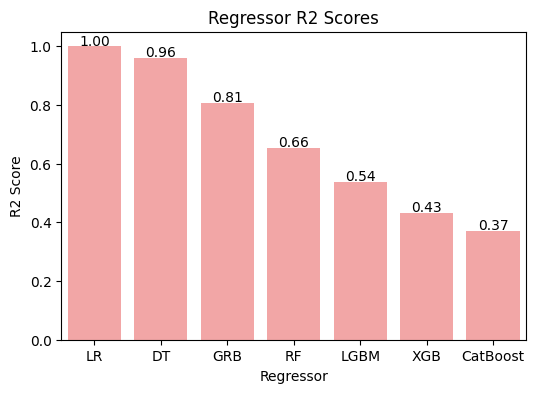

In [24]:
plt.figure(figsize=(6,4))
chart = sns.barplot(x=regressor_names, y=r2_scores, color = '#ff9999')
for i, v in enumerate(r2_scores):
    chart.text(i, v + 0.005, '{:.2f}'.format(v), ha="center")
chart.set(xlabel="Regressor", ylabel="R2 Score")
chart.set_title("Regressor R2 Scores")